
# Hyperparameter Sweeps for Parking Data in St. Gallen with LSTM

In this project, we use Hyperparemter sweeps with Pytorch on "Weights & Biases". For further details, check out this [Colab](http://wandb.me/sweeps-colab).

A lot of inspirations come from [this GitHub repository](https://github.com/SheezaShabbir/Time-series-Analysis-using-LSTM-RNN-and-GRU)

## Imports

In [1]:
import wandb
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from models import LSTMModel, RNNModel, GRUModel
from scaler import Scaler
from log_scaler import LogScaler
from data.metadata.metadata import parking_data_labels
from data.preprocessing.preprocess_features import PreprocessFeatures

## Login to W&B

In [2]:
wandb.login()

wandb: Currently logged in as: mr-perseus (parcaster). Use `wandb login --relogin` to force relogin


True

## Defining the sweep config

We define the sweep config via dict in our Jupyter notebook. You can find more information on sweeps in the [documentation](https://docs.wandb.com/sweeps/configuration).

You can find a list of all configuration options [here](https://docs.wandb.com/library/sweeps/configuration) and a big collection of examples in YAML format [here](https://github.com/wandb/examples/tree/master/examples/keras/keras-cnn-fashion).

We use some information for good values from this [source](https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046).

In [3]:
sweep_config = {
    'method': 'random',
    'metric': {
        'goal': 'minimize',
        'name': 'loss (test)'
    },
    'parameters': {
        'model': {
            'value': 'lstm'
        },
        'X_scaler': {
            'values': ['standard', 'minmax', 'robust', 'maxabs']
        },
        'y_scaler': {
            'values': ['standard', 'minmax', 'robust', 'maxabs']
            #  For log scaler run:
            # 'values': ['log']
        },
        'batch_size': {
            'distribution': 'q_log_uniform_values',
            'max': 256,
            'min': 32,
            'q': 8
        },
        'train_val_ratio': {
            'distribution': 'q_uniform',
            'max': 0.85,
            'min': 0.6,
            'q': 0.05
        },
        'dropout': {
            'distribution': 'q_uniform',
            'max': 0.5,
            'min': 0,
            'q': 0.05
        },
        'num_layers': {
            'distribution': 'q_log_uniform_values',
            'max': 64,
            'min': 2,
            'q': 1
        },
        'epochs': {
            'distribution': 'q_log_uniform_values',
            'max': 100,
            'min': 5,
            'q': 5
        },
        'fc_layer_size': {
            'values': [25, 50, 100, 150, 200, 300, 400, 500]
        },
        'learning_rate': {
            'values': [0.00001, 0.0001, 0.001, 0.01, 0.1]
        },
        'optimizer': {
            'values': ['adam', 'sgd']
        }
    }
}

## Initialize the setup

You can find the runs [here](https://wandb.ai/parcaster/pp-sg-lstm).

In [4]:
sweep_id = wandb.sweep(sweep_config, project="pp-sg-lstm")
# sweep_id = wandb.agent(sweep_config, project="pp-sg-lstm")

Create sweep with ID: e0ryn1tt
Sweep URL: https://wandb.ai/parcaster/pp-sg-lstm/sweeps/e0ryn1tt


## Run the sweep agent

### Define Your Training Procedure

Before we can actually execute the sweep, we need to define the training procedure that uses those values.

In the functions below, we define a simple fully-connected neural network in PyTorch, and add the following `wandb` tools to log model metrics, visualize performance and output and track our experiments:
* [**`wandb.init()`**](https://docs.wandb.com/library/init) – Initialize a new W&B Run. Each Run is a single execution of the training function.
* [**`wandb.config`**](https://docs.wandb.com/library/config) – Save all your hyperparameters in a configuration object so they can be logged. Read more about how to use `wandb.config` [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-config/Configs_in_W%26B.ipynb).
* [**`wandb.log()`**](https://docs.wandb.com/library/log) – log model behavior to W&B. Here, we just log the performance; see [this Colab](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-log/Log_(Almost)_Anything_with_W%26B_Media.ipynb) for all the other rich media that can be logged with `wandb.log`.

For more details on instrumenting W&B with PyTorch, see [this Colab](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb).

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Training on {device}")

train_data_path = "../data/preprocessing/01_pp_sg_train_cleaned.csv"
test_data_path = "../data/preprocessing/01_pp_sg_test_cleaned.csv"


# To run with data starting from 01/03/2022 use:
# train_data_path = "../data/preprocessing/02_pp_sg_train_cleaned.csv"
# test_data_path = "../data/preprocessing/02_pp_sg_test_cleaned.csv"


def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        model_path = os.path.join(wandb.run.dir, "model_scripted.pt")

        X, y, input_dim, output_dim = load_features_labels(train_data_path)
        X_train, X_val, y_train, y_val = split_train_val(X, y, config.train_val_ratio)
        X_test, y_test, _, _ = load_features_labels(test_data_path)
        X_scaler = apply_scaler(config.X_scaler)
        y_scaler = apply_scaler(config.y_scaler)
        X_train_scaled, X_val_scaled, X_test_scaled = X_scaler.scale(X_train, X_val, X_test)
        y_train_scaled, y_val_scaled, y_test_scaled = y_scaler.scale(y_train, y_val, y_test)
        train_loader = build_dataset(config.batch_size, X_train_scaled, y_train_scaled)
        val_loader = build_dataset(config.batch_size, X_val_scaled, y_val_scaled)
        test_loader = build_dataset(config.batch_size, X_test_scaled, y_test_scaled)
        network = build_network(config.fc_layer_size, config.dropout, config.num_layers, input_dim, output_dim,
                                config.model)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

        best_val_loss = float('inf')
        best_epoch = 0

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, train_loader, optimizer, config.batch_size, input_dim)
            avg_val_loss = val_epoch(network, val_loader, config.batch_size, input_dim, y_scaler)
            wandb.log({"train loss (MSE scaled)": avg_loss, "epoch": epoch})
            wandb.log({"val loss (RMSE)": avg_val_loss, "epoch": epoch})  # For log scaler use MSE scaled

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch
                print(f"New best validation loss: {best_val_loss} at epoch {best_epoch}. Saving model to {model_path}.")
                save_model(network, model_path)

        best_model = torch.jit.load(model_path, map_location=device)
        avg_test_loss, test_outputs, test_targets = test_network(best_model, test_loader, config.batch_size, input_dim,
                                                                 y_scaler)
        wandb.log({"test loss (RMSE)": avg_test_loss})
        wandb.log({"best epoch": best_epoch})
        plot_test_prediction(test_outputs, test_targets)
        save_scaler(X_scaler, y_scaler)


Training on cuda


### Load the data

We load the data from the CSV files and split it into training and validation sets.

In [6]:
def load_features_labels(csv_path):
    df = pd.read_csv(csv_path, sep=";")

    preprocess_features = PreprocessFeatures(df)

    y = df[parking_data_labels]
    X, input_dim = preprocess_features.get_features_for_model()

    output_dim = len(y.columns)

    print(f"Input dimension: {input_dim}, columns: {X.columns}")
    print(f"Output dimension: {output_dim}, columns: {y.columns}")

    return X, y, input_dim, output_dim


def split_train_val(X, y, train_val_ratio):
    train_size = int(len(X) * train_val_ratio)
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    return X_train, X_val, y_train, y_val

### Apply the scaler

We apply the scaler to the data.

In [7]:
def apply_scaler(scaler):
    if scaler == "standard":
        return Scaler(StandardScaler())
    elif scaler == "minmax":
        return Scaler(MinMaxScaler())
    elif scaler == "robust":
        return Scaler(RobustScaler())
    elif scaler == "maxabs":
        return Scaler(MaxAbsScaler())
    elif scaler == "log":
        return Scaler(LogScaler())
    else:
        raise ValueError(f"Invalid scaler value: {scaler}")

### Build the dataset

We build the dataset from features (X) and labels (y). This is used for training data, validation data and test data.

In [8]:
def build_dataset(batch_size, X, y):
    features = torch.Tensor(X)
    targets = torch.Tensor(y)

    dataset = TensorDataset(features, targets)

    return DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

### Build the network

We build the network with the given hyperparameters. We can choose between RNN, LSTM and GRU.

We decided to use LSTM, because it is the most powerful of the three and we have a lot of data.

In [9]:
def build_network(fc_layer_size, dropout, num_layers, input_dim, output_dim, model):
    if model == "rnn":
        network = RNNModel(input_dim=input_dim, hidden_dim=fc_layer_size, layer_dim=num_layers, output_dim=output_dim,
                           dropout_prob=dropout)
    elif model == "lstm":
        network = LSTMModel(input_dim=input_dim, hidden_dim=fc_layer_size, layer_dim=num_layers, output_dim=output_dim,
                            dropout_prob=dropout)
    elif model == "gru":
        network = GRUModel(input_dim=input_dim, hidden_dim=fc_layer_size, layer_dim=num_layers, output_dim=output_dim,
                           dropout_prob=dropout)
    else:
        raise ValueError(f"Invalid model value: {model}")

    return network.to(device)


### Build the optimizer

We build the optimizer with the given hyperparameters. We can choose between SGD and Adam.

In [10]:
def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

### Define the training and validation epochs, and the test network

- `train_epoch` is used in every epoch to train the network. The training loss is calculated with the mean squared error.
- `val_epoch` is used in every epoch to validate the network. The validation loss is calculated with the mean squared error.
- `test_network` is used after the training to test the network. The test loss is calculated with the mean squared error.

In [11]:
def calculate_loss(output, target, y_scaler):
    output_inverted = y_scaler.inverse_transform(output.detach().cpu().numpy())
    target_inverted = y_scaler.inverse_transform(target.detach().cpu().numpy())
    loss = mean_squared_error(output_inverted, target_inverted, squared=False)
    return loss, output_inverted, target_inverted


def train_epoch(network, loader, optimizer, batch_size, input_dim):
    losses = []
    network.train()
    for _, (data, target) in enumerate(loader):
        data, target = data.view([batch_size, -1, input_dim]).to(device), target.to(device)
        optimizer.zero_grad()

        # output = network(data.unsqueeze(0)).squeeze() # See https://medium.com/@mike.roweprediger/using-pytorch-to-train-an-lstm-forecasting-model-e5a04b6e0e67

        # ➡ Forward pass
        loss = F.mse_loss(network(data), target)
        losses.append(loss.item())

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch train loss (MSE scaled)": loss.item()})

    return np.mean(losses)


def val_epoch(network, loader, batch_size, input_dim, y_scaler):
    losses = []
    with torch.no_grad():
        network.eval()
        for _, (data, target) in enumerate(loader):
            data, target = data.view([batch_size, -1, input_dim]).to(device), target.to(device)
            output = network(data)
            loss, _, _ = calculate_loss(output, target, y_scaler)
            losses.append(loss)

            wandb.log({"batch val loss (RMSE)": loss.item()})

            # For log scaler use loss directly from network (not RMSE from inverse_transform).
            # loss = F.mse_loss(network(data), target)
            # losses.append(loss.item())
            # wandb.log({"batch val loss (MSE scaled)": loss.item()})

    return np.mean(losses)


def test_network(network, loader, batch_size, input_dim, y_scaler):
    outputs = []
    targets = []
    losses = []
    with torch.no_grad():
        network.eval()
        for _, (data, target) in enumerate(loader):
            data, target = data.view([batch_size, -1, input_dim]).to(device), target.to(device)
            output = network(data)
            loss, output_inverted, target_inverted = calculate_loss(output, target, y_scaler)
            losses.append(loss)
            outputs.append(output_inverted)
            targets.append(target_inverted)

    return np.mean(losses), outputs, targets


## Plot the test prediction

We plot the prediction and the target.

In [12]:
def plot_test_prediction(outputs, targets):
    for i, (output, target) in enumerate(zip(outputs, targets)):
        if i % 50 != 0:
            continue

        df_output = pd.DataFrame(output, columns=parking_data_labels)
        df_target = pd.DataFrame(target, columns=parking_data_labels)

        n_features = len(df_output.columns)

        # Plotting
        fig, ax = plt.subplots(figsize=(10, 6))

        # Setting the positions of the bars
        ind = np.arange(n_features)  # the x locations for the groups
        width = 0.35  # the width of the bars

        # Plotting bars for each row
        bars1 = ax.bar(ind - width / 2, df_output.iloc[0], width, label='Prediction (from model)')
        bars2 = ax.bar(ind + width / 2, df_target.iloc[0], width, label='Target (form dataset)')

        # Adding some text for labels, title, and custom x-axis tick labels
        ax.set_xlabel('Parking garages')
        ax.set_ylabel('Free parking spots')
        ax.set_title(f'Comparison of Two Rows in a Bar Chart {i}')
        ax.set_xticks(ind)
        ax.set_xticklabels(df_output.columns)
        ax.legend()

        plt.show()


## Save the model and the scaler

This can later be reused to predict real values. (see app.py)

In [13]:
def save_model(network, model_path):
    model_scripted = torch.jit.script(network)
    model_scripted.save(model_path)


def save_scaler(X_scaler, y_scaler):
    X_scaler_path = os.path.join(wandb.run.dir, "X_scaler.pkl")
    y_scaler_path = os.path.join(wandb.run.dir, "y_scaler.pkl")
    X_scaler.save(X_scaler_path)
    y_scaler.save(y_scaler_path)

# Start the agent and run the sweep

That someone is an `agent`, and they are created with `wandb.agent`.
To get going, the agent just needs to know
1. which Sweep it's a part of (`sweep_id`)
2. which function it's supposed to run (here, `train`)
3. (optionally) how many configs to ask the Controller for (`count`)

wandb: Agent Starting Run: kbsmq3bd with config:
wandb: 	X_scaler: minmax
wandb: 	batch_size: 120
wandb: 	dropout: 0.1
wandb: 	epochs: 5
wandb: 	fc_layer_size: 25
wandb: 	learning_rate: 0.001
wandb: 	model: lstm
wandb: 	num_layers: 26
wandb: 	optimizer: adam
wandb: 	train_val_ratio: 0.7000000000000001
wandb: 	y_scaler: robust


Input dimension: 18, columns: Index(['ferien', 'feiertag', 'covid_19', 'olma_offa', 'temperature_2m_max',
       'temperature_2m_min', 'rain_sum', 'snowfall_sum', 'sin_minute',
       'cos_minute', 'sin_hour', 'cos_hour', 'sin_weekday', 'cos_weekday',
       'sin_day', 'cos_day', 'sin_month', 'cos_month'],
      dtype='object')
Output dimension: 14, columns: Index(['P24', 'P44', 'P42', 'P33', 'P23', 'P25', 'P21', 'P31', 'P53', 'P32',
       'P22', 'P52', 'P51', 'P43'],
      dtype='object')
Input dimension: 18, columns: Index(['ferien', 'feiertag', 'covid_19', 'olma_offa', 'temperature_2m_max',
       'temperature_2m_min', 'rain_sum', 'snowfall_sum', 'sin_minute',
       'cos_minute', 'sin_hour', 'cos_hour', 'sin_weekday', 'cos_weekday',
       'sin_day', 'cos_day', 'sin_month', 'cos_month'],
      dtype='object')
Output dimension: 14, columns: Index(['P24', 'P44', 'P42', 'P33', 'P23', 'P25', 'P21', 'P31', 'P53', 'P32',
       'P22', 'P52', 'P51', 'P43'],
      dtype='object')
New best

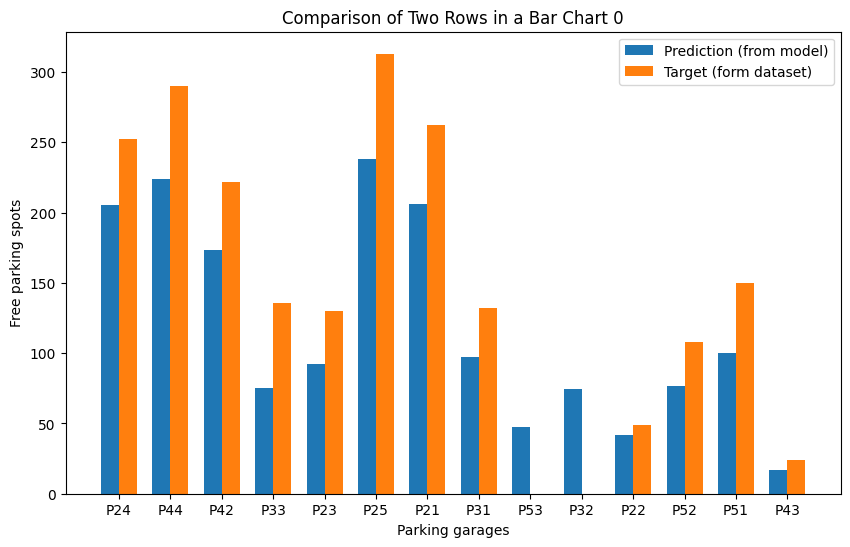

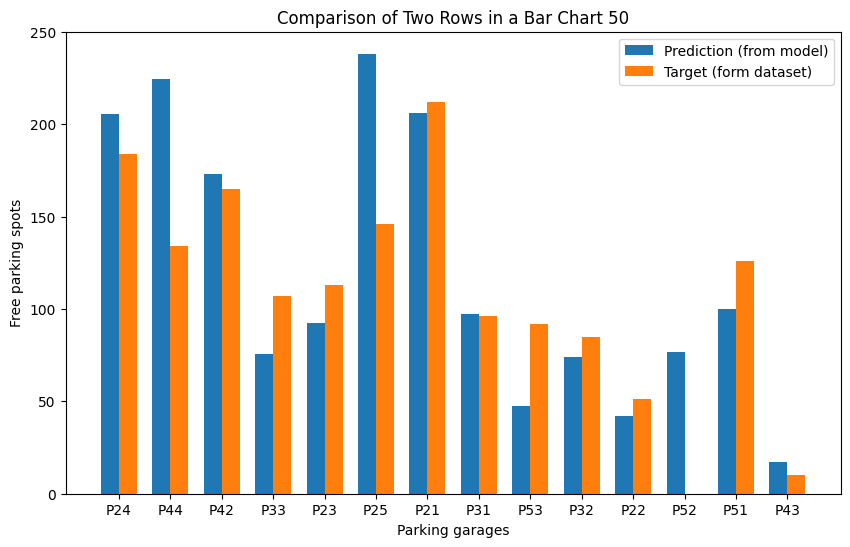

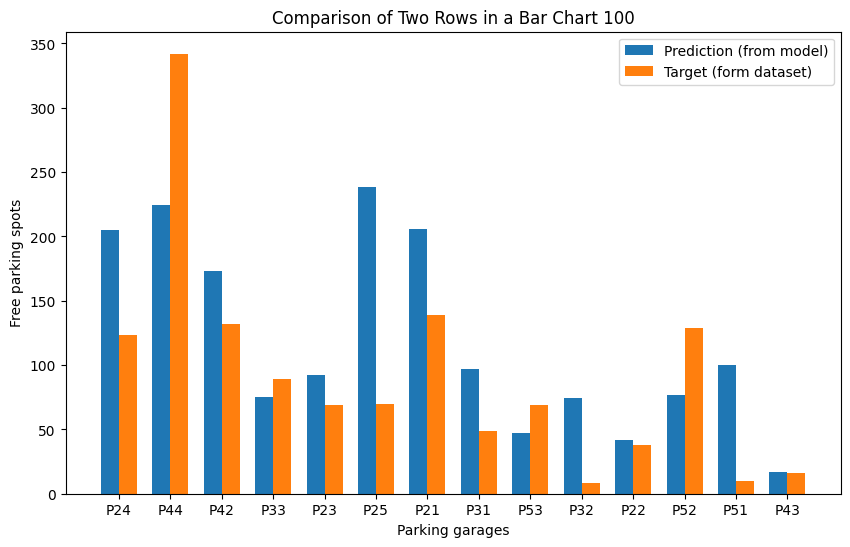

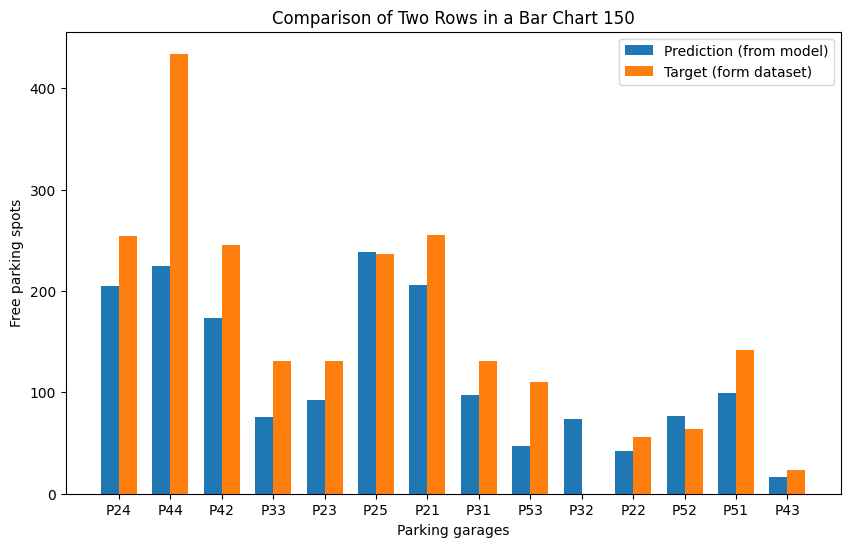

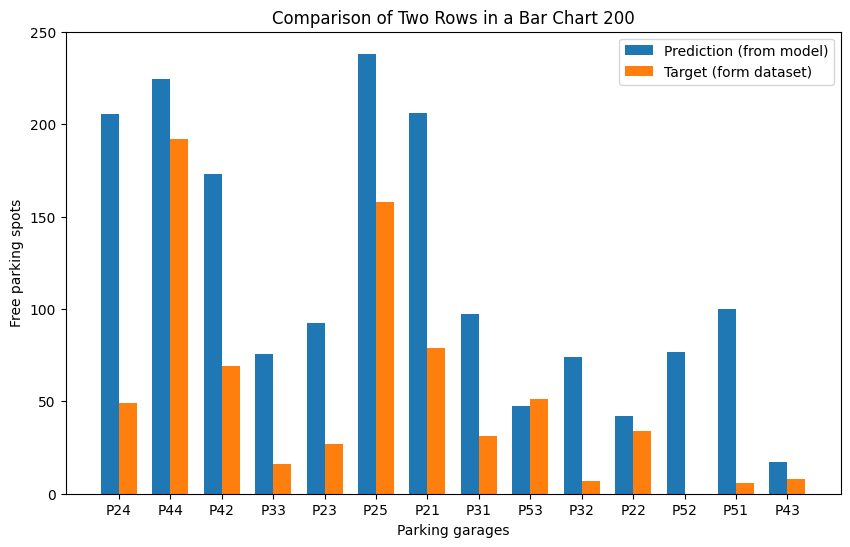

batch train loss (MSE scaled),▆▂▃▄▂▃▃▂▆█▁▃▂▂▄▁▅▃▃▃▂▁▄▃▆▂▂▃▂▂▄▂▆▃▃▄▂▂▄▃
batch val loss (RMSE),▃▁▂▂▂▄▃▂▄▂▁▃▃▄▂▃▄▂▁▂▂█▃▂▄▂▂▂▂▂▃▂▂▂▂▂▂▃▂▃
best epoch,▁
epoch,▁▁▃▃▅▅▆▆██
test loss (RMSE),▁
train loss (MSE scaled),█▁▂▁▁
val loss (RMSE),█▃▁▁▁
batch train loss (MSE scaled),0.29036
batch val loss (RMSE),54.2933
best epoch,3
epoch,4


In [14]:
wandb.agent(sweep_id, train, count=1)